In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np

from network import Population, RateNetwork
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule
from sequences import GaussianSequence

logging.basicConfig(level=logging.INFO)

In [5]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
ctx = Population(N=1000, tau=1e-2, phi=phi, name='ctx')
bg = Population(N=1000, tau=1e-2, phi=phi, name='bg')
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8) 

S, P = 1, 3
sequences_ctx = [GaussianSequence(P,ctx.size) for i in range(S)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])
sequences_bg = [GaussianSequence(P,ctx.size) for i in range(S)]
patterns_bg = np.stack([s.inputs for s in sequences_bg])

J_cc = SparseConnectivity(source=ctx, target=ctx, p=0.5)
synapse_cc = LinearSynapse(J_cc.K, A=6)
J_cc.store_attractors(patterns_ctx[0], patterns_ctx[0], synapse_cc.h_EE, plasticity.f, plasticity.g)
J_bb = SparseConnectivity(source=bg, target=bg, p=0.5)
synapse_bb = LinearSynapse(J_bb.K, A=6)
J_bb.store_attractors(patterns_bg[0], patterns_bg[0], synapse_bb.h_EE, plasticity.f, plasticity.g)
J_cb  = SparseConnectivity(source=bg, target=ctx, p=0.5)
synapse_cb = LinearSynapse(J_cb.K, A=3)
J_cb.store_attractors(patterns_bg[0], patterns_ctx[0], synapse_cb.h_EE, plasticity.f, plasticity.g)

J_bc = SparseConnectivity(source=ctx, target=bg, p=0.5)
synapse_bc = LinearSynapse(J_cc.K, A=0)
J_bc.store_sequences(patterns_ctx, patterns_bg, synapse_bc.h_EE, plasticity.f, plasticity.g)

net_ctx = RateNetwork(ctx, c_EE=J_cc, c_IE=J_bc, formulation=4)
net_bg = RateNetwork(bg, c_II=J_bb, c_EI=J_cb, formulation=4)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Storing attractors
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 6916.19it/s]
INFO:connectivity:Building connections from bg to bg
INFO:connectivity:Storing attractors
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 7536.99it/s]
INFO:connectivity:Building connections from bg to ctx
INFO:connectivity:Storing attractors
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 6961.80it/s]
INFO:connectivity:Building connections from ctx to bg
INFO:connectivity:Storing sequences
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix


In [6]:
init_input_ctx = np.random.RandomState().normal(0,1,size=patterns_ctx[0][0].shape)
init_input_bg = np.random.RandomState().normal(0,1,size=patterns_bg[0][0].shape)
T=5
net_ctx.simulate_euler2(net_bg, T, init_input_ctx, init_input_bg)

INFO:network:Integrating network dynamics
100%|███████████████████████████████████████| 4999/4999 [00:55<00:00, 90.56it/s]


In [7]:
overlaps = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi)
correlations = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi, correlation=True)

INFO:sequences:Computing overlaps
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 14.89it/s]
INFO:sequences:Computing correlations
100%|█████████████████████████████████████████████| 3/3 [00:12<00:00,  4.12s/it]


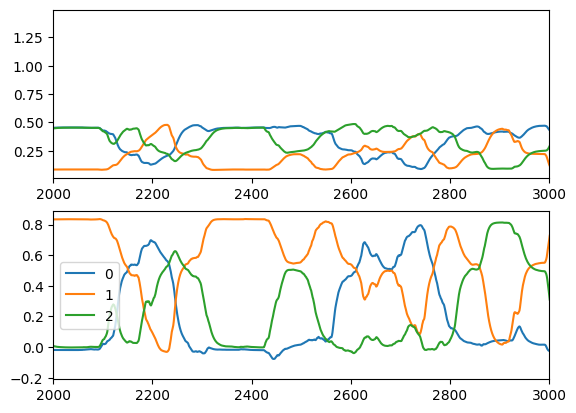

In [17]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,1)
i=2000
axes[0].set_xlim(i, i+1000)
axes[1].set_xlim(i, i+1000)
for i in overlaps:
    axes[0].plot(i)
for i, v in enumerate(correlations):
    axes[1].plot(v, label=str(i))
axes[1].legend()
